<a href="https://colab.research.google.com/github/hoihui/pkgs/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

In [3]:
# !pip3 install -U torch torchvision
import torch
cuda=torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
torch.__version__, cuda

('1.1.0', False)

In [1]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf
tf.__version__, tf.keras.__version__

('2.0.0-alpha0', '2.2.4-tf')

* https://arxiv.org/pdf/1508.06576.pdf
* https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf


1. Use VGG19 to extract style from a **style image**
2. Use VGG19 to extract content from a **content image**
3. Minimize the combined **style loss** and **content loss** on the target(output) image.
$${\cal L}=\sum(T_c-C_c)^2+a\sum_i w_i(T_{s,i}-S_{s,i})^2,$$
where $C$=content image, $S$=style image, and $T$=target image. $X_c=(21+1)^{\rm th}$ layer's feature in VGG19 net. $X_{s,i}$=Gram Matrix at layer #{0,5,10,19,28}, and $w_i=[1,0.75,0.2,0.2,0.2]$  correspondingly.
$a\sim10^6$ is an hyperparameter to be tuned.
4. Adjust the ration of the two losses to get desired output

# Torch

https://classroom.udacity.com/courses/ud188/lessons/c1541fd7-e6ec-4177-a5b1-c06f1ce09dd8/concepts/558e6218-96dc-47e2-85cd-9c779a263fb3

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/style-transfer/Style_Transfer_Solution.ipynb

## Load Images and VGG19

In [5]:
from torchvision import transforms
from io import BytesIO
import requests
style='https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/2880px-Tsunami_by_hokusai_19th_century.jpg'
content='https://www.collegemagazine.com/wp-content/uploads/2014/09/odk-fountain.jpg'

style = Image.open(BytesIO(requests.get(style).content)).convert('RGB')
content = Image.open(BytesIO(requests.get(content).content)).convert('RGB')

in_transform = transforms.Compose([transforms.Resize(400),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.485, 0.456, 0.406), 
                                                        (0.229, 0.224, 0.225))])

style = in_transform(style)[:3,:,:].unsqueeze(0).to(device)
content = in_transform(content)[:3,:,:].unsqueeze(0).to(device)

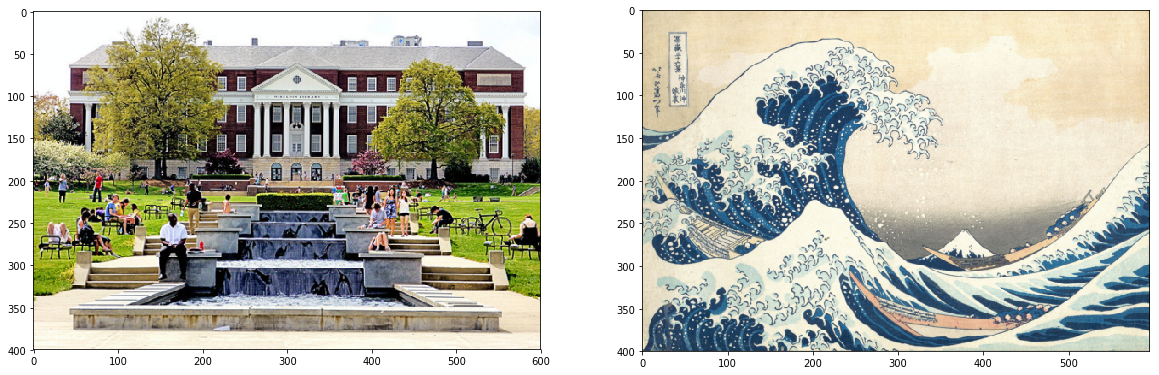

In [6]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
def im_convert(tensor):    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [4]:
from torchvision import models
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to(device);

## Extracting style/content features from vgg

layers to use are from Gatys et al (2016):

In [7]:
# layers = {'0': 'conv1_1',
#           '5': 'conv2_1', 
#           '10': 'conv3_1', 
#           '19': 'conv4_1',
#           '21': 'conv4_2',  ## content representation
#           '28': 'conv5_1'}
layernames = ['0','5','10','19','21','28']  # 21 is content representation
def get_features(x, layernames=layernames, model=vgg):        
    features = []
    for name, layer in model._modules.items():  #pass through the OrderedDict
        x = layer(x)
        if name in layernames:
            features.append(x)            
    return features

content_features=get_features(content)
style_features=get_features(style)

Compute gram matrix for summary of style:

In [9]:
def gram_matrix(tensor):# https://en.wikipedia.org/wiki/Gramian_matrix
    _, d, h, w = tensor.size()  #batch_size, depth, height, and width
    tensor = tensor.view(d, h * w)
    return torch.mm(tensor, tensor.t())

print(style_features[0].shape)
style_grams = [ gram_matrix(style_feature) for style_feature in style_features ]

torch.Size([1, 64, 400, 595])


In [0]:
# start off the target as a copy of *content* image
# then iteratively change its style
image = content.clone().requires_grad_(True).to(device)

## Defining and Optimizing wrt Loss function

In [0]:
import torch.optim as optim
style_weights = [1.,0.75,0.2, 0.2,0,0.2]  #corresponds to layernames; later layers are more fine-grained styles
content_weight = 1 
style_weight = 5e6

optimizer = optim.Adam([image], lr=0.003)
steps = 2000  # how many steps
show_every = 400

for ii in range(1, steps+1):
    
    image_features = get_features(image)
    content_loss = torch.mean((image_features[4] - content_features[4])**2)
    
    # computing style loss
    style_loss = 0
    for layerid in range(len(style_weights)):
        image_feature = image_features[layerid]
        image_gram = gram_matrix(image_feature)
        _, d, h, w = image_feature.shape
        style_gram = style_grams[layerid]
        layer_style_loss = style_weights[layerid] * torch.mean((image_gram - style_gram)**2)  #want similar gram matrices
        style_loss += layer_style_loss / (d * h * w)
        
    # total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(image))
        plt.show()

## Final Display

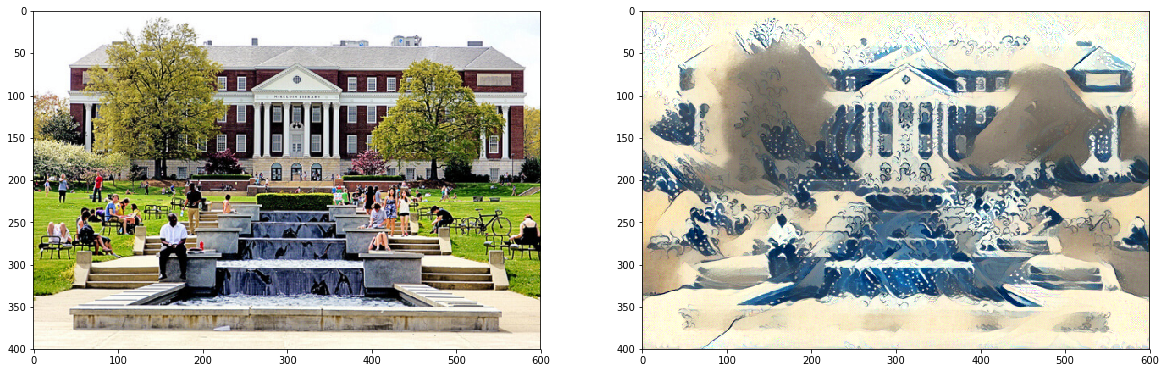

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(image))

# Tensorflow

https://www.tensorflow.org/alpha/tutorials/generative/style_transfer

## Load Image

In [4]:
style = 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'
content = 'https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg'
import urllib, tempfile, os
os.chdir(tempfile.gettempdir())
urllib.request.urlretrieve(style,'style.jpg')
urllib.request.urlretrieve(content,'content.jpg')

('content.jpg', <http.client.HTTPMessage at 0xb3301c3c8>)

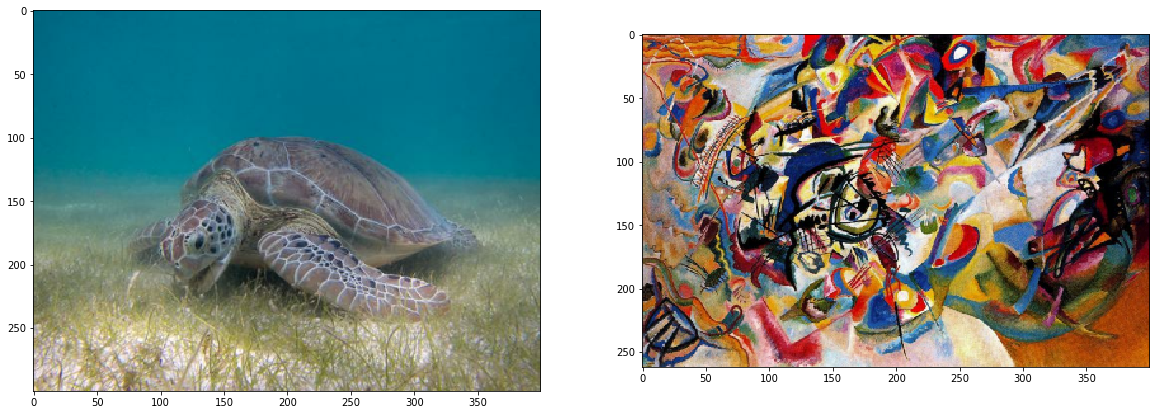

In [45]:
imgsize=400    #longer dimension
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # from [0,255] to [0,1)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = imgsize / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]   # add new dim for batch dim
    return img

style = load_img('style.jpg')
content = load_img('content.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(content[0])  # 1st dim = batchsize 
ax2.imshow(style[0])

## Load Model

In [24]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# test forward
x = tf.keras.applications.vgg19.preprocess_input(content*255)
x = tf.image.resize(x, (224, 224))
vgg(x)

for layer in vgg.layers: print(layer.name,end='; ')

input_6; block1_conv1; block1_conv2; block1_pool; block2_conv1; block2_conv2; block2_pool; block3_conv1; block3_conv2; block3_conv3; block3_conv4; block3_pool; block4_conv1; block4_conv2; block4_conv3; block4_conv4; block4_pool; block5_conv1; block5_conv2; block5_conv3; block5_conv4; block5_pool; 

## Extract style/content

In [29]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
content_layer = 'block5_conv2'

def get_features(x, layernames=style_layers+[content_layer], model=vgg):
    x = tf.keras.applications.vgg19.preprocess_input(x*255)    
    extractor = tf.keras.Model([model.input], [model.get_layer(name).output for name in layernames])
    return extractor(x)

content_feature = get_features(content)[-1]
style_features = get_features(style)[:-1]

In [30]:
def gram_matrix(tensor):# https://en.wikipedia.org/wiki/Gramian_matrix
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    input_shape = tf.shape(tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

print(style_features[0].shape)
style_grams = [ gram_matrix(style_feature) for style_feature in style_features ]

(1, 262, 400, 64)


In [54]:
# start off the target as a copy of *content* image
# then iteratively change its style
image = tf.Variable(content)

## Basic training

In [ ]:
# one step
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2/5
content_weight=1e4

def train_step(image):
    with tf.GradientTape() as tape:
        features = get_features(image)
        image_content = features[-1]
        image_styles = features[:-1]
        image_style_grams = [ gram_matrix(e) for e in image_styles ]
        
        style_loss = tf.add_n([tf.reduce_mean((style_grams[i]-image_style_grams[i])**2) for i in range(len(style_layers))])
        style_loss *= style_weight

        content_loss = tf.reduce_mean((content_feature-image_content)**2) 
        content_loss *= content_weight
        
        loss = style_loss + content_loss

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    target.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))  # keep the pixel values between 0 and 1
    
train_step(image)
# plt.imshow(image.read_value()[0])

W0528 13:19:39.538120 4541236672 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


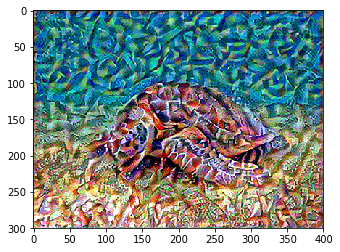

In [42]:
# full
from IPython.display import clear_output
epochs = 2
steps_per_epoch = 10

for _ in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    clear_output(wait=True)
    plt.imshow(image.read_value()[0])
    plt.show()

## Total variation loss

Reduce high frequency artifacts by an explicit regularization term on the high frequency components of the image ("total variation loss").

In [55]:
def total_variation_loss(image):  # subtract neighboring pixel values
    x_delta = image[:,:,1:,:] - image[:,:,:-1,:]
    y_delta = image[:,1:,:,:] - image[:,:-1,:,:]
    return tf.reduce_mean(x_delta**2) + tf.reduce_mean(y_delta**2)
total_variation_weight=1e8

In [56]:
# one step
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2/5
content_weight=1e4

# @tf.function  #compile
def train_step(image):
    with tf.GradientTape() as tape:
        features = get_features(image)
        image_content = features[-1]
        image_styles = features[:-1]
        image_style_grams = [ gram_matrix(e) for e in image_styles ]
        
        style_loss = tf.add_n([tf.reduce_mean((style_grams[i]-image_style_grams[i])**2) for i in range(len(style_layers))])
        style_loss *= style_weight

        content_loss = tf.reduce_mean((content_feature-image_content)**2) 
        content_loss *= content_weight 
        
        ############################ CHANGED ############################
        high_freq_loss = total_variation_weight * total_variation_loss(image)        
        loss = style_loss + content_loss + high_freq_loss 
        ############################ CHANGED ############################

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    target.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)) 
    
train_step(image)
# plt.imshow(image.read_value()[0])

W0528 13:41:13.073902 4541236672 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


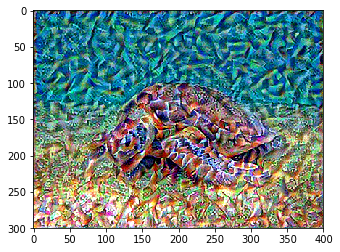

In [57]:
# full
from IPython.display import clear_output
epochs = 5
steps_per_epoch = 10

for _ in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    clear_output(wait=True)
    plt.imshow(image.read_value()[0])
    plt.show()